In [3]:
!pip install xmltodict

In [4]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from math import ceil
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,f1_score,ConfusionMatrixDisplay,classification_report

import xmltodict

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip "/content/drive/My Drive/dataset_road" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/Speed Limit 100/001036_jpg.rf.ca42fc70291b1202ec2a8b2c4ee883ad.jpg  
  inflating: /content/dataset/train/Speed Limit 100/00007_00000_00022_png.rf.54a547dd927fd8796a86c1565e926031.xml  
  inflating: /content/dataset/train/Speed Limit 100/001206_jpg.rf.8a5c5cff39957ab4aa0328ac121a8053.xml  
  inflating: /content/dataset/train/Speed Limit 100/00007_00043_00012_png.rf.4b31a6c2f1c9573d9eaacbaf7c812053.xml  
  inflating: /content/dataset/train/Speed Limit 100/001062_jpg.rf.577a1ed9865c7431d04f1174e8297bba.xml  
  inflating: /content/dataset/train/Speed Limit 100/00007_00041_00004_png.rf.43ce27b2a1a3f2a063603fe6c8d80444.jpg  
  inflating: /content/dataset/train/Speed Limit 100/road765_png.rf.e353454481811bcd2d8f0b7adfcfe35c.jpg  
  inflating: /content/dataset/train/Speed Limit 100/00007_00041_00017_png.rf.3dd427c6546586db8c9bb3f01ead6f92.xml  
  inflating: /content/dataset/train/Speed Limit 100/FisheyeCamer

In [5]:
dataset_root = '/content/dataset'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
class RoadSignDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform

        self.class_names = sorted(os.listdir(self.root_dir))

        self.image_paths = []
        self.labels = []

        for label_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)

            image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]

            self.image_paths.extend([os.path.join(class_dir, img) for img in image_files])
            self.labels.extend([label_idx] * len(image_files))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
train_dataset = RoadSignDataset(root_dir=dataset_root, split='train', transform=transform)
test_dataset = RoadSignDataset(root_dir=dataset_root, split='test', transform=transform)
val_dataset = RoadSignDataset(root_dir=dataset_root, split='valid', transform=transform)

In [8]:
def get_data_loader(dataset,batch_size,shuffle):
  return DataLoader(dataset,batch_size=batch_size,shuffle=shuffle)

In [9]:
def train(num_epochs, model, train_loader, val_loader, criterion, optimizer, patience=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    total_steps = len(train_loader)

    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    max_loss = float('inf')
    epoch_change = 0

    for epoch in range(num_epochs):
        losses_train = 0
        total_train = 0
        correct_train = 0

        model.train()
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses_train += loss.item()
            total_train += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()

        mean_loss_epoch = losses_train / total_steps
        train_loss.append(mean_loss_epoch)
        train_accuracy.append((correct_train / total_train) * 100)

        model.eval()
        losses_val = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                images_val, labels_val = data[0].to(device), data[1].to(device)
                outputs_val = model(images_val)
                loss_val = criterion(outputs_val, labels_val)
                losses_val += loss_val.item()
                _, predicted = torch.max(outputs_val.data, 1)
                correct_val += (predicted == labels_val).sum().item()
                total_val += labels_val.size(0)

        val_epoch_loss = losses_val / len(val_loader)
        val_loss.append(val_epoch_loss)
        val_accuracy.append((correct_val / total_val) * 100)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {mean_loss_epoch:.4f}, Accuracy: {(correct_train / total_train) * 100:.2f}%, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {(correct_val / total_val) * 100:.2f}%')

        if val_epoch_loss < max_loss:
            max_loss = val_epoch_loss
            epoch_change = 0
        else:
            epoch_change += 1

        if epoch_change >= patience:
            print(f'Early stop after {epoch+1} epochs')
            break

    print('Training completed')

    return train_loss, train_accuracy, val_accuracy, model , val_loss


In [10]:
def test(model, test_loader):
	model.eval()
	device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
	print("Device: {}".format(device))
	torch.cuda.empty_cache()
	model.to(device)
	test_preds = []
	test_labels = []
	with torch.no_grad():
		for images, labels in test_loader:
			images, labels = images.to(device), labels.to(device)
			outputs = model(images)
			_, predicted = torch.max(outputs, 1)
			test_preds.extend(predicted.cpu().numpy())
			test_labels.extend(labels.cpu().numpy())

			test_accuracy = accuracy_score(test_labels, test_preds)
			test_recall = recall_score(test_labels, test_preds,average='micro')
			test_f1score = f1_score(test_labels, test_preds,average='micro')
			test_precision=precision_score(test_labels, test_preds,average='micro')
			conf_matrix = confusion_matrix(test_labels, test_preds)
	return test_accuracy,test_recall,test_f1score,test_precision,conf_matrix


In [11]:
from sklearn.manifold import TSNE
import numpy as np
def extract_features(model, data_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device)
            labels.extend(labels_batch.numpy())
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
    return np.array(features), np.array(labels)

def plot_tsne(train_features, train_labels, test_features, test_labels, dataset_name):
    tsne = TSNE(n_components=2, random_state=42)
    train_features_tsne = tsne.fit_transform(train_features)
    test_features_tsne = tsne.fit_transform(test_features)

    plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    for i in range(len(train_dataset.class_names)):
        plt.scatter(train_features_tsne[train_labels == i, 0], train_features_tsne[train_labels == i, 1], label=f'{train_dataset.class_names[i]} (Train)', marker='o', alpha=0.5)
    plt.title(f't-SNE visualization of Train data')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i in range(len(test_dataset.class_names)):
        plt.scatter(test_features_tsne[test_labels == i, 0], test_features_tsne[test_labels == i, 1], label=f'{test_dataset.class_names[i]} (Test)', marker='x', alpha=0.5)
    plt.title(f't-SNE visualization of Test data')
    plt.legend()

    plt.suptitle(f't-SNE visualization of {dataset_name} data', fontsize=16)
    plt.show()

Results of the batch_size=16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 2.2717, Accuracy: 16.34%, Val Loss: 2.2954, Val Accuracy: 11.73%
Epoch [2/25], Loss: 2.2301, Accuracy: 18.94%, Val Loss: 2.2924, Val Accuracy: 11.73%
Epoch [3/25], Loss: 2.1364, Accuracy: 23.96%, Val Loss: 2.2953, Val Accuracy: 8.87%
Epoch [4/25], Loss: 1.9956, Accuracy: 28.87%, Val Loss: 2.1660, Val Accuracy: 17.27%
Epoch [5/25], Loss: 1.9101, Accuracy: 31.68%, Val Loss: 1.9749, Val Accuracy: 33.12%
Epoch [6/25], Loss: 1.8281, Accuracy: 36.03%, Val Loss: 12.7547, Val Accuracy: 13.47%
Epoch [7/25], Loss: 1.7576, Accuracy: 37.42%, Val Loss: 9.2860, Val Accuracy: 10.30%
Epoch [8/25], Loss: 1.6852, Accuracy: 40.66%, Val Loss: 2.4499, Val Accuracy: 22.82%
Epoch [9/25], Loss: 1.5805, Accuracy: 43.22%, Val Loss: 4.2126, Val Accuracy: 19.65%
Epoch [10/25], Loss: 1.5157, Accuracy: 45.96%, Val Loss: 2.1495, Val Accuracy: 30.74%
Early stop after 10 epochs
Training completed
Device: cuda:0
Test Accuracy: 30.71%
Test Precision: 0.30707070707070705
Test Recall: 0.307070707070707

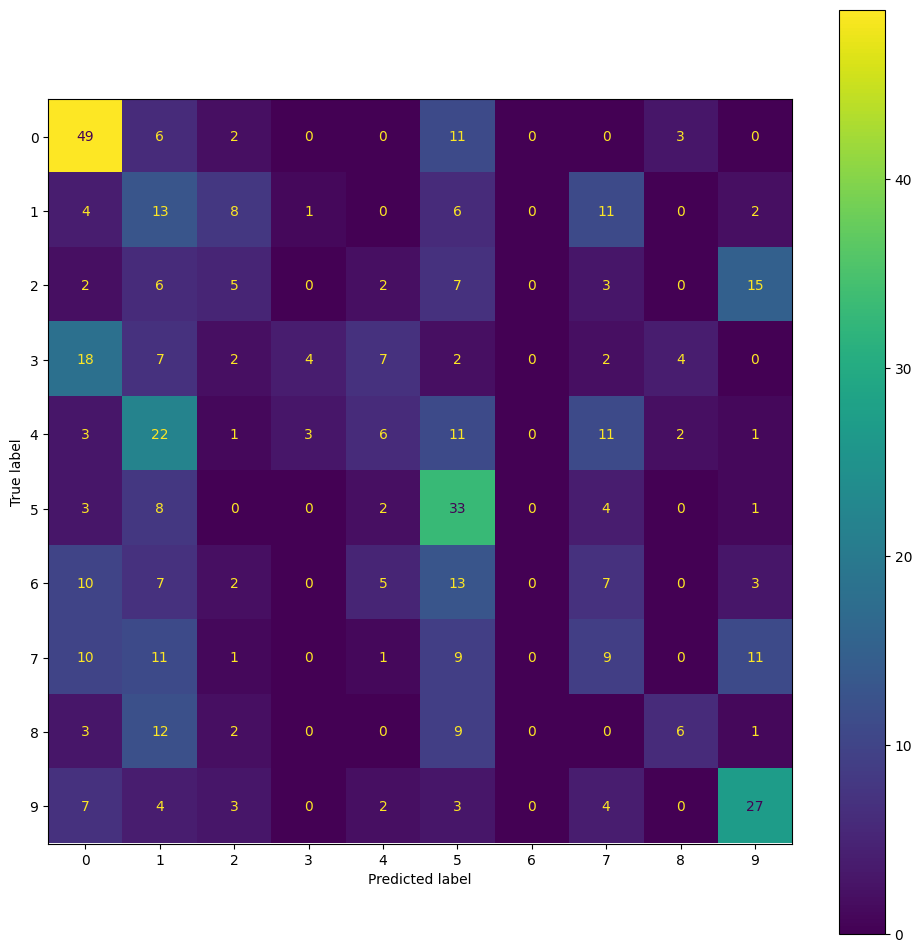

Results of the batch_size=32


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 2.2857, Accuracy: 12.67%, Val Loss: 2.2985, Val Accuracy: 11.73%
Epoch [2/25], Loss: 2.2570, Accuracy: 17.34%, Val Loss: 2.2952, Val Accuracy: 11.73%
Epoch [3/25], Loss: 2.2307, Accuracy: 18.16%, Val Loss: 2.2931, Val Accuracy: 11.73%
Epoch [4/25], Loss: 2.1973, Accuracy: 21.54%, Val Loss: 2.2913, Val Accuracy: 11.73%
Epoch [5/25], Loss: 2.1447, Accuracy: 23.75%, Val Loss: 2.2919, Val Accuracy: 11.73%
Epoch [6/25], Loss: 2.0754, Accuracy: 25.35%, Val Loss: 2.2941, Val Accuracy: 8.87%
Epoch [7/25], Loss: 2.0074, Accuracy: 29.30%, Val Loss: 2.2890, Val Accuracy: 8.87%
Epoch [8/25], Loss: 1.9112, Accuracy: 32.32%, Val Loss: 2.1564, Val Accuracy: 17.91%
Epoch [9/25], Loss: 1.8349, Accuracy: 34.64%, Val Loss: 2.1073, Val Accuracy: 25.04%
Epoch [10/25], Loss: 1.7659, Accuracy: 39.05%, Val Loss: 2.5388, Val Accuracy: 19.49%
Epoch [11/25], Loss: 1.7025, Accuracy: 40.37%, Val Loss: 2.2942, Val Accuracy: 25.67%
Epoch [12/25], Loss: 1.6063, Accuracy: 43.97%, Val Loss: 2.2973, 

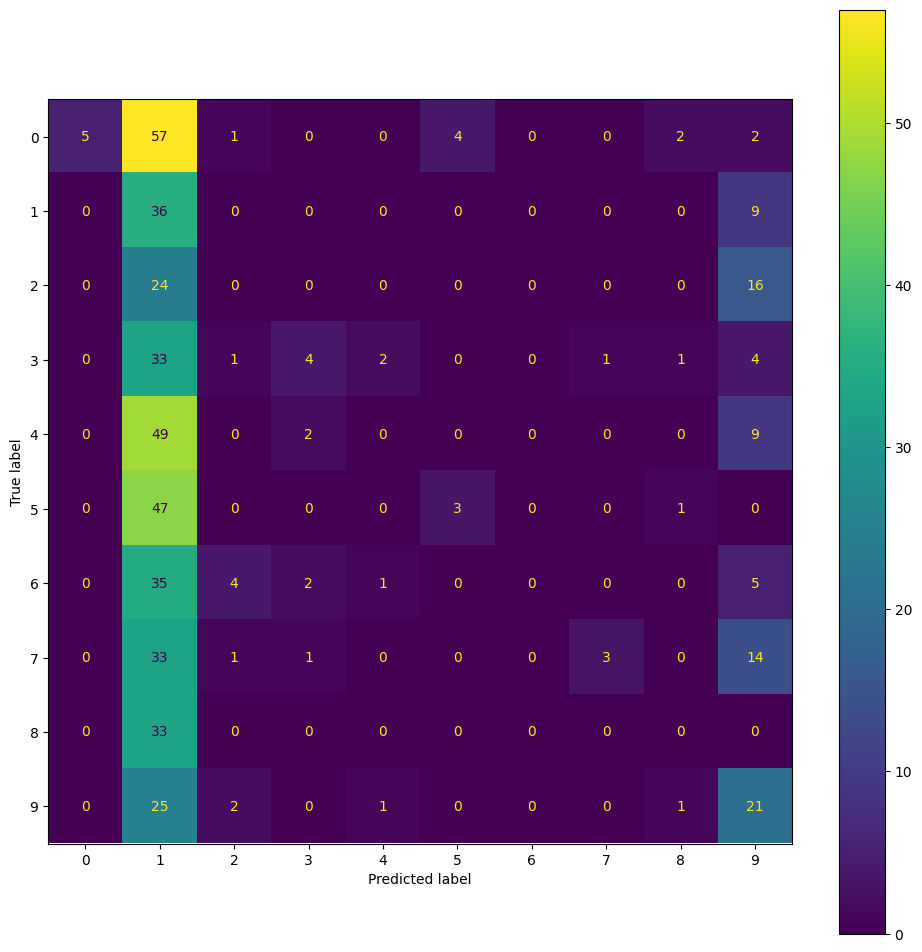

Results of the batch_size=64


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 2.2953, Accuracy: 12.42%, Val Loss: 2.3026, Val Accuracy: 12.84%
Epoch [2/25], Loss: 2.2757, Accuracy: 15.24%, Val Loss: 2.3007, Val Accuracy: 12.84%
Epoch [3/25], Loss: 2.2606, Accuracy: 18.69%, Val Loss: 2.2988, Val Accuracy: 11.73%
Epoch [4/25], Loss: 2.2522, Accuracy: 17.87%, Val Loss: 2.2974, Val Accuracy: 11.73%
Epoch [5/25], Loss: 2.2393, Accuracy: 18.80%, Val Loss: 2.2959, Val Accuracy: 11.73%
Epoch [6/25], Loss: 2.2285, Accuracy: 19.47%, Val Loss: 2.2944, Val Accuracy: 11.73%
Epoch [7/25], Loss: 2.2163, Accuracy: 21.04%, Val Loss: 2.2938, Val Accuracy: 11.73%
Epoch [8/25], Loss: 2.1967, Accuracy: 22.57%, Val Loss: 2.2933, Val Accuracy: 11.73%
Epoch [9/25], Loss: 2.1656, Accuracy: 24.60%, Val Loss: 2.2934, Val Accuracy: 11.73%
Epoch [10/25], Loss: 2.1081, Accuracy: 27.84%, Val Loss: 2.2939, Val Accuracy: 8.87%
Epoch [11/25], Loss: 2.0361, Accuracy: 28.94%, Val Loss: 2.2991, Val Accuracy: 8.87%
Epoch [12/25], Loss: 1.9581, Accuracy: 30.08%, Val Loss: 2.3113, 

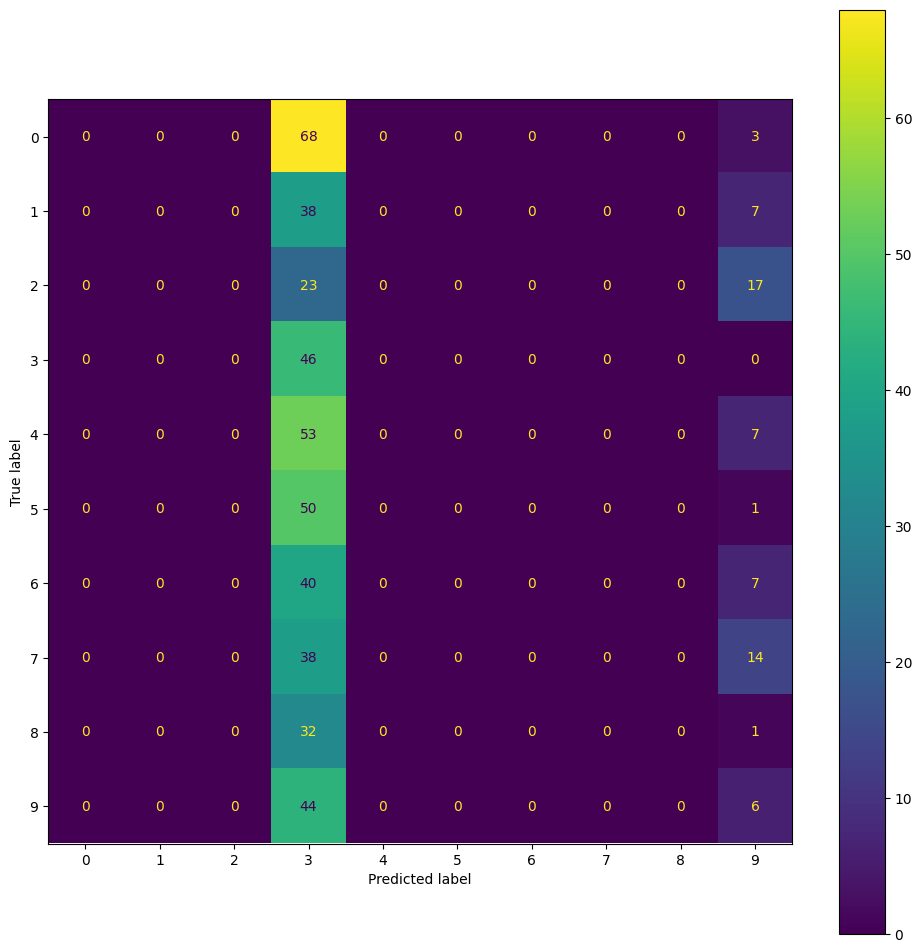

In [36]:
train_loss_hyperparameters1={}
train_acc_hyperparameters1={}
val_acc_hyperparameters1={}
learning_rate=0.0001
hyper_parameters={"batch_size":[16,32,64]}
num_epochs=25

for batch_size in hyper_parameters["batch_size"]:
  print('==========')
  print(f'Results of the batch_size={batch_size}')
  train_loader = get_data_loader(train_dataset, batch_size, shuffle=True)
  test_loader = get_data_loader(test_dataset, batch_size, shuffle=True)
  val_loader = get_data_loader(val_dataset, batch_size, shuffle=True)
  model = models.mobilenet_v3_large(pretrained=False)
  num_ftrs = model.classifier[3].in_features
  model.classifier[3] = nn.Linear(num_ftrs,10)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


  train_loss,train_accuracy,val_accuracy,model,val_loss=train(num_epochs,model,train_loader,val_loader,criterion,optimizer)

  train_loss_hyperparameters1[f"lr{batch_size}"]=train_loss
  train_acc_hyperparameters1[f"lr{batch_size}"]=train_accuracy
  val_acc_hyperparameters1[f"lr{batch_size}"]=val_accuracy


  test_accuracy,test_recall,test_f1score,test_precision,conf_matrix = test(model, test_loader)
  print("Test Accuracy: {:.2f}%".format(test_accuracy*100))
  print("Test Precision:",test_precision)
  print("Test Recall:",test_recall)
  print("Test F1score:",test_f1score)
  print("Confusion Matrix on Test Set:")
  figname = "Confusion_matrix"
  fig, ax = plt.subplots(figsize=(12,12))
  ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
  plt.show()

Results of the learning rate=0.001


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 6.8226, Accuracy: 14.60%, Val Loss: 6.8217, Val Accuracy: 11.73%
Epoch [2/25], Loss: 6.4954, Accuracy: 17.62%, Val Loss: 6.7251, Val Accuracy: 11.73%
Epoch [3/25], Loss: 5.8273, Accuracy: 17.16%, Val Loss: 6.5889, Val Accuracy: 11.73%
Epoch [4/25], Loss: 4.3416, Accuracy: 14.13%, Val Loss: 6.0587, Val Accuracy: 11.73%
Epoch [5/25], Loss: 2.4327, Accuracy: 20.72%, Val Loss: 4.7604, Val Accuracy: 8.87%
Epoch [6/25], Loss: 2.0379, Accuracy: 28.09%, Val Loss: 3.5896, Val Accuracy: 8.87%
Epoch [7/25], Loss: 1.9166, Accuracy: 30.69%, Val Loss: 3.1571, Val Accuracy: 9.03%
Epoch [8/25], Loss: 1.8251, Accuracy: 34.32%, Val Loss: 2.7499, Val Accuracy: 15.06%
Epoch [9/25], Loss: 1.7226, Accuracy: 37.91%, Val Loss: 2.0074, Val Accuracy: 35.02%
Epoch [10/25], Loss: 1.6894, Accuracy: 39.98%, Val Loss: 1.9120, Val Accuracy: 36.45%
Epoch [11/25], Loss: 1.5910, Accuracy: 44.39%, Val Loss: 1.8852, Val Accuracy: 31.85%
Epoch [12/25], Loss: 1.5285, Accuracy: 45.57%, Val Loss: 1.9150, V

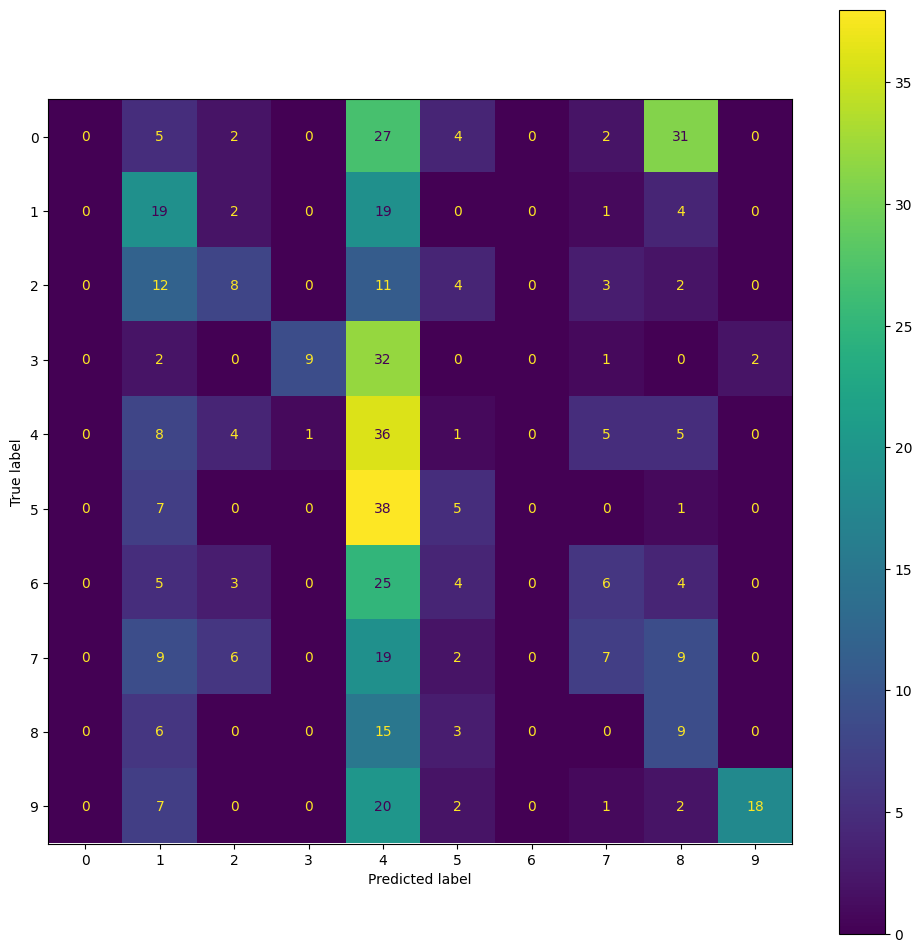

Results of the learning rate=0.0001


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 6.8214, Accuracy: 14.45%, Val Loss: 6.8215, Val Accuracy: 11.73%
Epoch [2/25], Loss: 6.5075, Accuracy: 17.98%, Val Loss: 6.7158, Val Accuracy: 11.73%
Epoch [3/25], Loss: 5.8143, Accuracy: 15.88%, Val Loss: 6.5547, Val Accuracy: 11.73%
Epoch [4/25], Loss: 3.9913, Accuracy: 14.31%, Val Loss: 5.9870, Val Accuracy: 11.73%
Epoch [5/25], Loss: 2.3444, Accuracy: 20.93%, Val Loss: 4.9779, Val Accuracy: 8.87%
Epoch [6/25], Loss: 2.0315, Accuracy: 29.41%, Val Loss: 3.6796, Val Accuracy: 8.87%
Epoch [7/25], Loss: 1.8844, Accuracy: 34.03%, Val Loss: 3.1728, Val Accuracy: 10.62%
Epoch [8/25], Loss: 1.7793, Accuracy: 36.21%, Val Loss: 2.9030, Val Accuracy: 15.21%
Epoch [9/25], Loss: 1.7073, Accuracy: 39.73%, Val Loss: 2.0943, Val Accuracy: 28.84%
Epoch [10/25], Loss: 1.6318, Accuracy: 42.47%, Val Loss: 2.5489, Val Accuracy: 21.08%
Epoch [11/25], Loss: 1.5888, Accuracy: 43.22%, Val Loss: 2.7311, Val Accuracy: 19.18%
Epoch [12/25], Loss: 1.5017, Accuracy: 45.67%, Val Loss: 1.7186, 

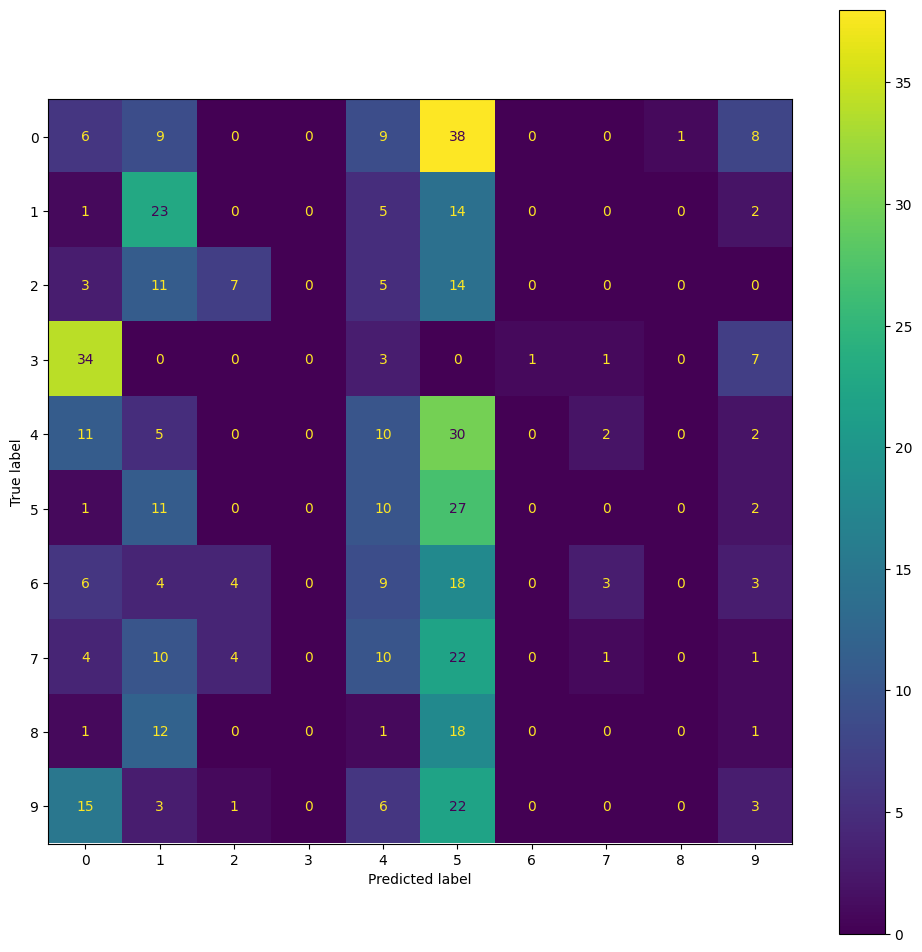

In [37]:
train_loss_hyperparameters={}
train_acc_hyperparameters={}
val_acc_hyperparameters={}
batch_size=32
hyper_parameters={"learning_rate":[0.001,0.0001]}
num_epochs=25


for learning_rate in hyper_parameters["learning_rate"]:
  print('==========')
  print(f'Results of the learning rate={learning_rate}')
  train_loader = get_data_loader(train_dataset, batch_size, shuffle=True)
  test_loader = get_data_loader(test_dataset, batch_size, shuffle=True)
  val_loader = get_data_loader(val_dataset, batch_size, shuffle=True)
  model2 =models.mobilenet_v3_large(pretrained=False)
  num_ftrs = model.classifier[3].in_features
  model.classifier[3] = nn.Linear(num_ftrs,10)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)



  train_loss,train_accuracy,val_accuracy,model,val_loss=train(num_epochs,model2,train_loader,val_loader,criterion,optimizer)

  train_loss_hyperparameters[f"lr{learning_rate}"]=train_loss
  train_acc_hyperparameters[f"lr{learning_rate}"]=train_accuracy
  val_acc_hyperparameters[f"lr{learning_rate}"]=val_accuracy


  test_accuracy,test_recall,test_f1score,test_precision,conf_matrix = test(model2, test_loader)
  print("Test Accuracy: {:.2f}%".format(test_accuracy*100))
  print("Test Precision:",test_precision)
  print("Test Recall:",test_recall)
  print("Test F1score:",test_f1score)
  print("Confusion Matrix on Test Set:")
  figname = "Confusion_matrix"
  fig, ax = plt.subplots(figsize=(12,12))
  ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
  plt.show()

Results of the loss_function=neg_log_likelihood


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: -0.0023, Accuracy: 0.00%, Val Loss: -0.0012, Val Accuracy: 0.00%
Epoch [2/25], Loss: -0.0047, Accuracy: 0.04%, Val Loss: -0.0022, Val Accuracy: 0.00%
Epoch [3/25], Loss: -0.0070, Accuracy: 0.28%, Val Loss: -0.0032, Val Accuracy: 0.00%
Epoch [4/25], Loss: -0.0094, Accuracy: 0.61%, Val Loss: -0.0041, Val Accuracy: 11.73%
Epoch [5/25], Loss: -0.0120, Accuracy: 2.81%, Val Loss: -0.0051, Val Accuracy: 11.73%
Epoch [6/25], Loss: -0.0142, Accuracy: 4.88%, Val Loss: -0.0059, Val Accuracy: 11.73%
Epoch [7/25], Loss: -0.0167, Accuracy: 7.73%, Val Loss: -0.0068, Val Accuracy: 11.73%
Epoch [8/25], Loss: -0.0192, Accuracy: 9.83%, Val Loss: -0.0081, Val Accuracy: 12.04%
Epoch [9/25], Loss: -0.0214, Accuracy: 12.32%, Val Loss: -0.0119, Val Accuracy: 14.58%
Epoch [10/25], Loss: -0.0237, Accuracy: 13.21%, Val Loss: -0.0183, Val Accuracy: 14.42%
Epoch [11/25], Loss: -0.0254, Accuracy: 14.17%, Val Loss: -0.0243, Val Accuracy: 14.26%
Epoch [12/25], Loss: -0.0278, Accuracy: 14.49%, Val 

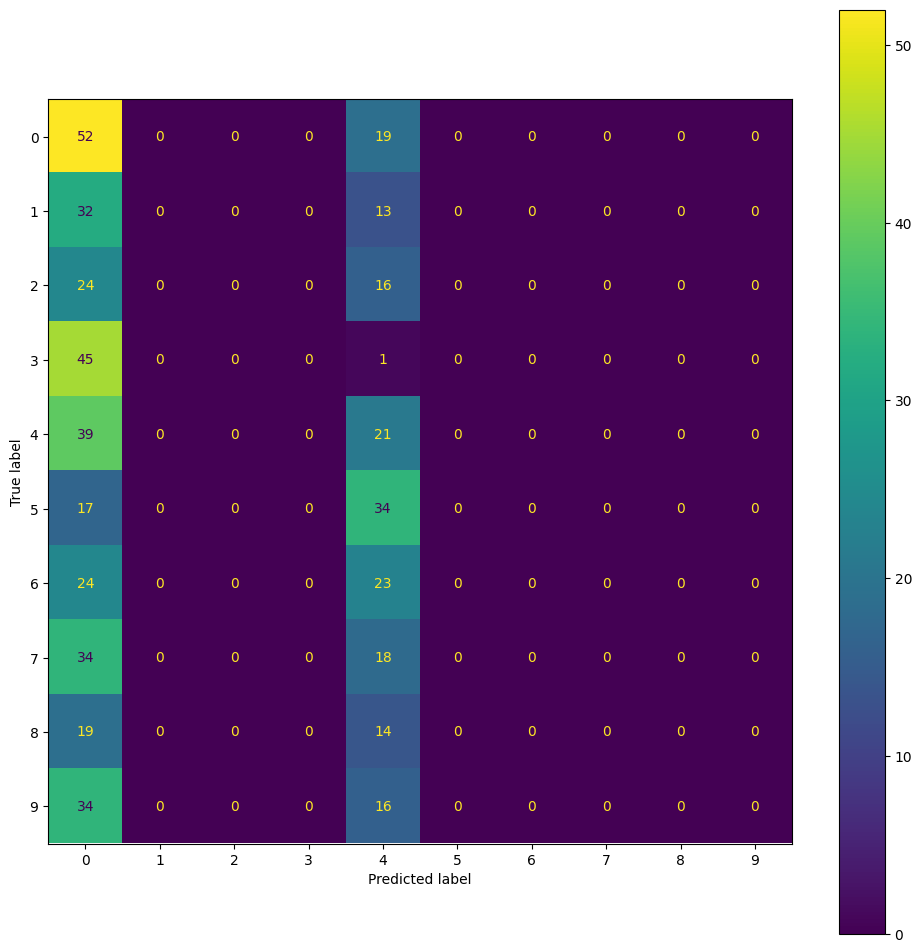

Results of the loss_function=cross_entropy


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25], Loss: 6.9087, Accuracy: 0.18%, Val Loss: 6.9065, Val Accuracy: 0.00%
Epoch [2/25], Loss: 6.9064, Accuracy: 0.36%, Val Loss: 6.9055, Val Accuracy: 0.00%
Epoch [3/25], Loss: 6.9042, Accuracy: 0.32%, Val Loss: 6.9044, Val Accuracy: 0.00%
Epoch [4/25], Loss: 6.9016, Accuracy: 1.28%, Val Loss: 6.9034, Val Accuracy: 11.73%
Epoch [5/25], Loss: 6.8997, Accuracy: 1.96%, Val Loss: 6.9023, Val Accuracy: 11.73%
Epoch [6/25], Loss: 6.8971, Accuracy: 3.88%, Val Loss: 6.9012, Val Accuracy: 11.73%
Epoch [7/25], Loss: 6.8952, Accuracy: 6.12%, Val Loss: 6.9000, Val Accuracy: 11.73%
Epoch [8/25], Loss: 6.8930, Accuracy: 8.90%, Val Loss: 6.8986, Val Accuracy: 11.73%
Epoch [9/25], Loss: 6.8907, Accuracy: 10.43%, Val Loss: 6.8954, Val Accuracy: 13.47%
Epoch [10/25], Loss: 6.8882, Accuracy: 12.67%, Val Loss: 6.8900, Val Accuracy: 14.74%
Epoch [11/25], Loss: 6.8859, Accuracy: 14.20%, Val Loss: 6.8849, Val Accuracy: 14.10%
Epoch [12/25], Loss: 6.8842, Accuracy: 14.99%, Val Loss: 6.8812, Val Accur

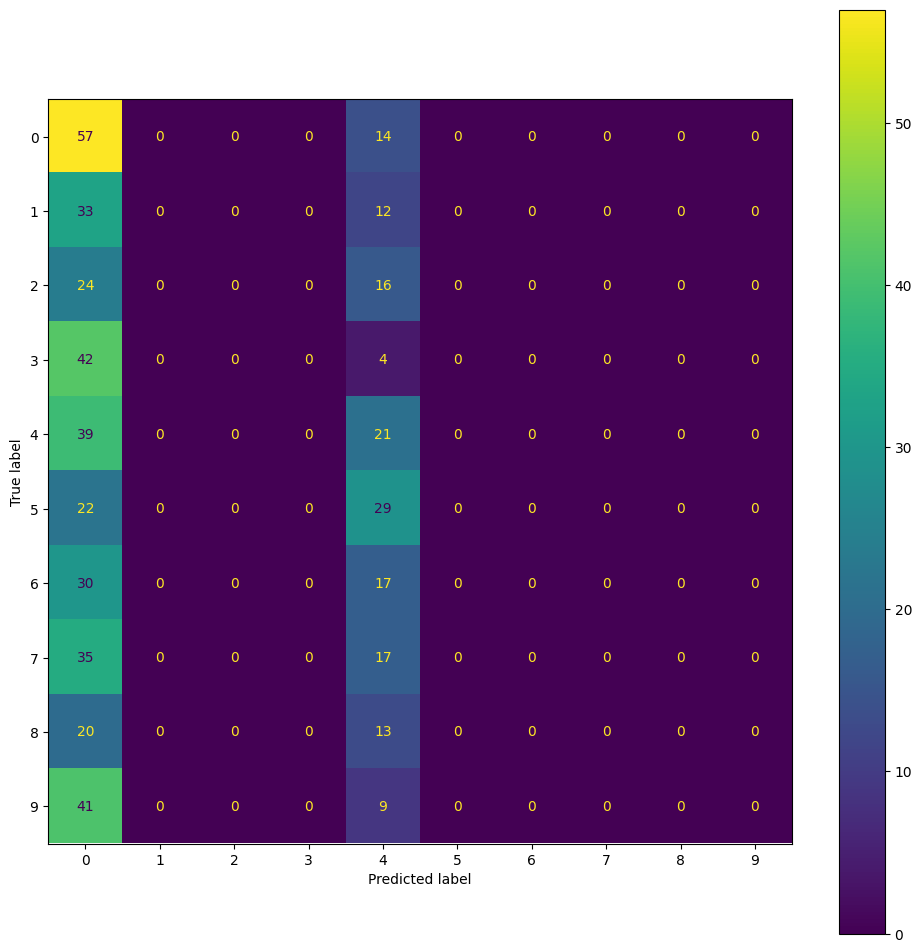

In [38]:
train_loss_hyperparameters2={}
train_acc_hyperparameters2={}
val_acc_hyperparameters2={}
learning_rate=0.0001
hyper_parameters={"loss_function":["neg_log_likelihood","cross_entropy"]}
num_epochs=25
batch_size=32

for loss_function in hyper_parameters["loss_function"]:
  print('==========')
  print(f'Results of the loss_function={loss_function}')
  train_loader = get_data_loader(train_dataset, batch_size, shuffle=True)
  test_loader = get_data_loader(test_dataset, batch_size, shuffle=True)
  val_loader = get_data_loader(val_dataset, batch_size, shuffle=True)
  model1 = models.mobilenet_v3_large(pretrained=False)
  num_ftrs = model.classifier[3].in_features
  model.classifier[3] = nn.Linear(num_ftrs,10)
  if loss_function=="neg_log_likelihood":
    criterion=nn.NLLLoss()
  elif loss_function=="cross_entropy":
    criterion=nn.CrossEntropyLoss()
  optimizer=torch.optim.SGD(model1.parameters(),lr=learning_rate)
  train_loss,train_accuracy,val_accuracy,model,val_loss=train(num_epochs,model1,train_loader,val_loader,criterion,optimizer)

  train_loss_hyperparameters2[f"lfn{loss_function}"]=train_loss
  train_acc_hyperparameters2[f"lfn{loss_function}"]=train_accuracy
  val_acc_hyperparameters2[f"lfn{loss_function}"]=val_accuracy



  test_accuracy,test_recall,test_f1score,test_precision,conf_matrix = test(model1, test_loader)
  print("Test Accuracy: {:.2f}%".format(test_accuracy*100))
  print("Test Precision:",test_precision)
  print("Test Recall:",test_recall)
  print("Test F1score:",test_f1score)
  print("Confusion Matrix on Test Set:")
  figname = "Confusion_matrix"
  fig, ax = plt.subplots(figsize=(12,12))
  ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
  plt.show()

In [13]:
!pip install flopper
from flopper import count_flops

Results of the batch_size=32


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FLOPs of the model MobileNetV3: 240.25 MFLOPs
Epoch [1/25], Loss: 6.8973, Accuracy: 2.24%, Val Loss: 6.8993, Val Accuracy: 11.73%
Epoch [2/25], Loss: 6.8748, Accuracy: 14.70%, Val Loss: 6.8897, Val Accuracy: 11.73%
Epoch [3/25], Loss: 6.8507, Accuracy: 17.55%, Val Loss: 6.8801, Val Accuracy: 11.73%
Epoch [4/25], Loss: 6.8279, Accuracy: 17.19%, Val Loss: 6.8706, Val Accuracy: 11.73%
Epoch [5/25], Loss: 6.8021, Accuracy: 16.73%, Val Loss: 6.8608, Val Accuracy: 11.73%
Epoch [6/25], Loss: 6.7756, Accuracy: 16.91%, Val Loss: 6.8511, Val Accuracy: 11.73%
Epoch [7/25], Loss: 6.7491, Accuracy: 17.02%, Val Loss: 6.8410, Val Accuracy: 11.73%
Epoch [8/25], Loss: 6.7155, Accuracy: 16.80%, Val Loss: 6.8280, Val Accuracy: 11.73%
Epoch [9/25], Loss: 6.6806, Accuracy: 17.16%, Val Loss: 6.7898, Val Accuracy: 15.21%
Epoch [10/25], Loss: 6.6426, Accuracy: 16.73%, Val Loss: 6.7062, Val Accuracy: 15.53%
Epoch [11/25], Loss: 6.6017, Accuracy: 16.38%, Val Loss: 6.6152, Val Accuracy: 15.21%
Epoch [12/25], Los

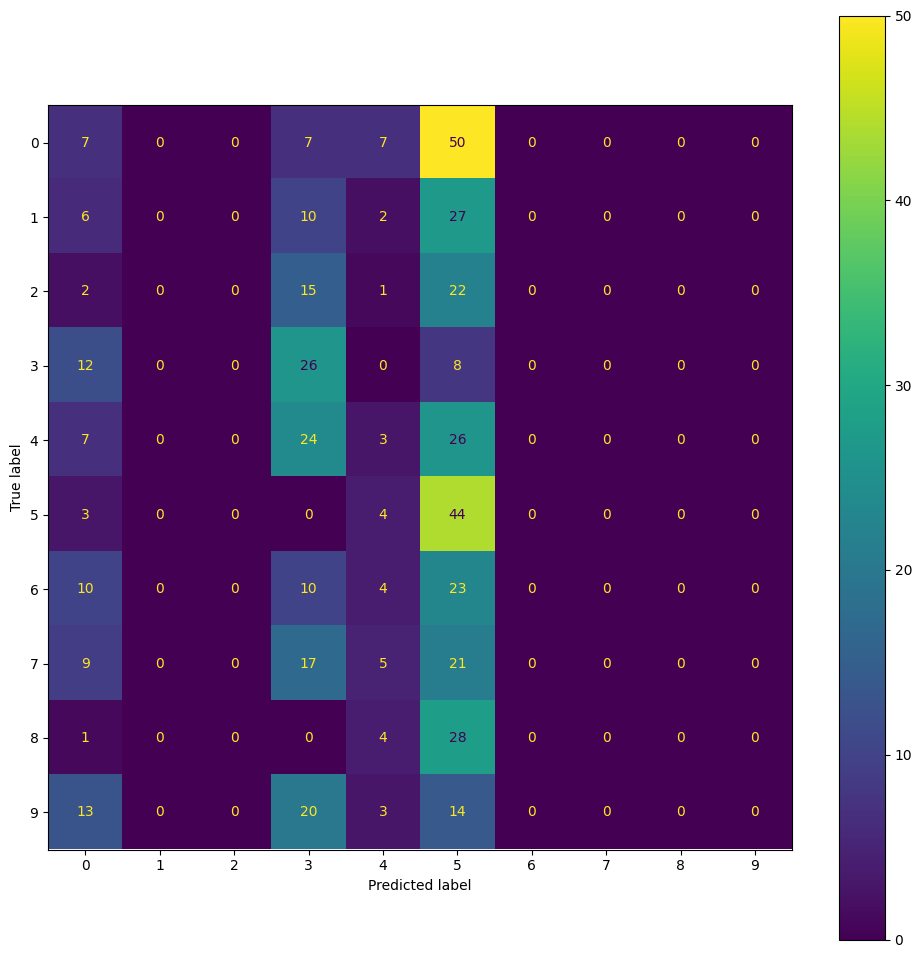

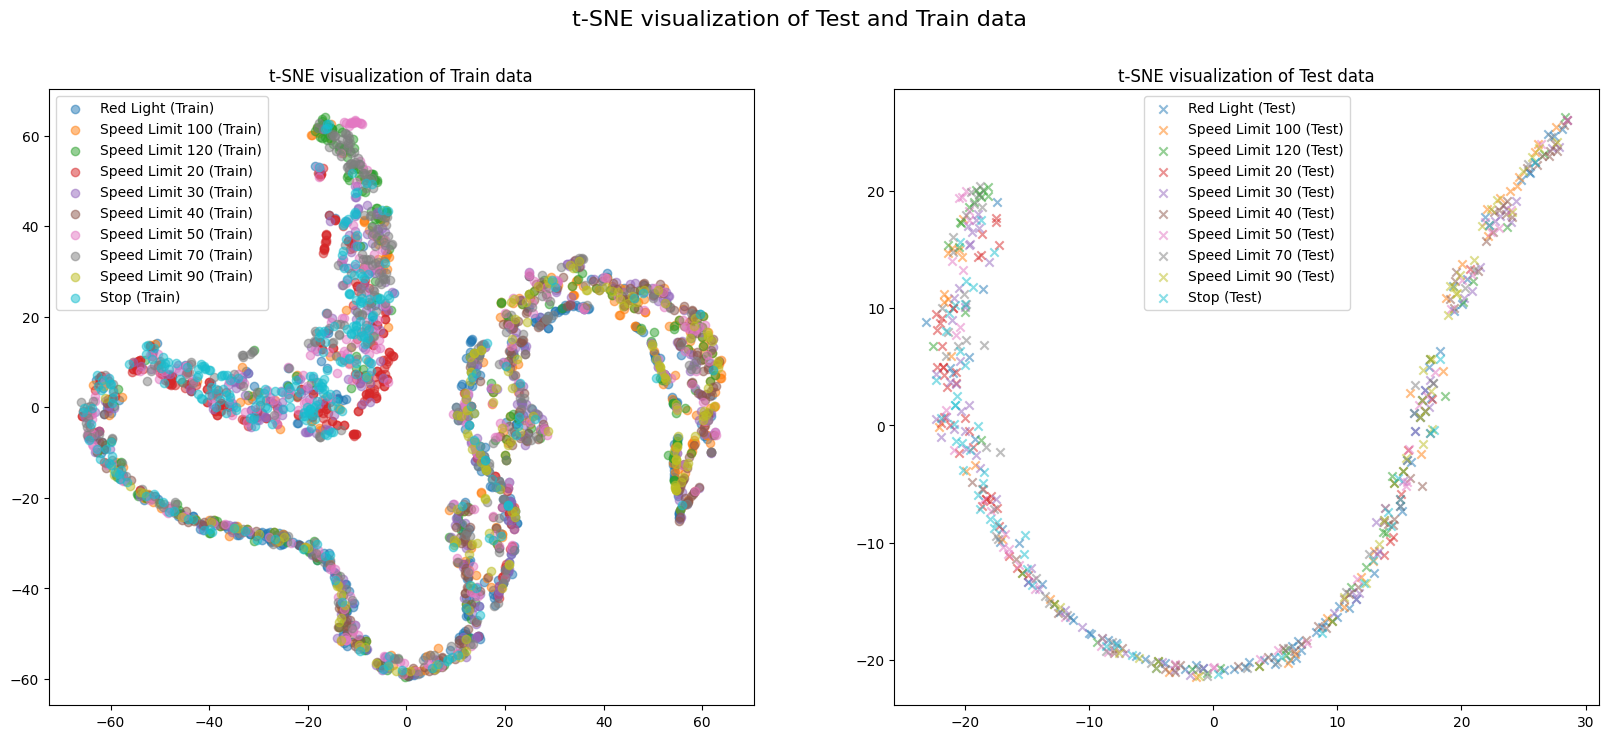

In [39]:
#final hyperparameters batch_size = 32, lr = 0.0001, cross entrop loss

train_loss_hyperparameters3={}
train_acc_hyperparameters3={}
val_acc_hyperparameters3={}
val_loss_hyperparameters3={}
learning_rate=0.001
hyper_parameters={"batch_size":[32]}
num_epochs=25

for batch_size in hyper_parameters["batch_size"]:
  print('==========')
  print(f'Results of the batch_size={batch_size}')
  train_loader = get_data_loader(train_dataset, batch_size, shuffle=True)
  test_loader = get_data_loader(test_dataset, batch_size, shuffle=True)
  val_loader = get_data_loader(val_dataset, batch_size, shuffle=True)
  model4 = models.mobilenet_v3_large(pretrained=False)
  num_ftrs = model.classifier[3].in_features
  model.classifier[3] = nn.Linear(num_ftrs,10)
  batch = torch.randn(1, 3, 224, 224)
  flops = count_flops(model4, batch)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model4.parameters(), lr=0.0001, momentum=0.9)

  train_loss,train_accuracy,val_accuracy,model,val_loss=train(num_epochs,model4,train_loader,val_loader,criterion,optimizer)

  train_loss_hyperparameters3[f"lr{batch_size}"]=train_loss
  train_acc_hyperparameters3[f"lr{batch_size}"]=train_accuracy
  val_acc_hyperparameters3[f"lr{batch_size}"]=val_accuracy
  val_loss_hyperparameters3[f"lr{batch_size}"]=val_loss

  test_accuracy,test_recall,test_f1score,test_precision,conf_matrix = test(model4, test_loader)
  print("Test Accuracy: {:.2f}%".format(test_accuracy*100))
  print("Test Precision:",test_precision)
  print("Test Recall:",test_recall)
  print("Test F1score:",test_f1score)
  print("Confusion Matrix on Test Set:")
  figname = "Confusion_matrix"
  fig, ax = plt.subplots(figsize=(12,12))
  ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
  plt.show()
  train_features, train_labels = extract_features(model4, train_loader)
  test_features, test_labels = extract_features(model4, test_loader)
  plot_tsne(train_features, train_labels, test_features, test_labels, "Test and Train")

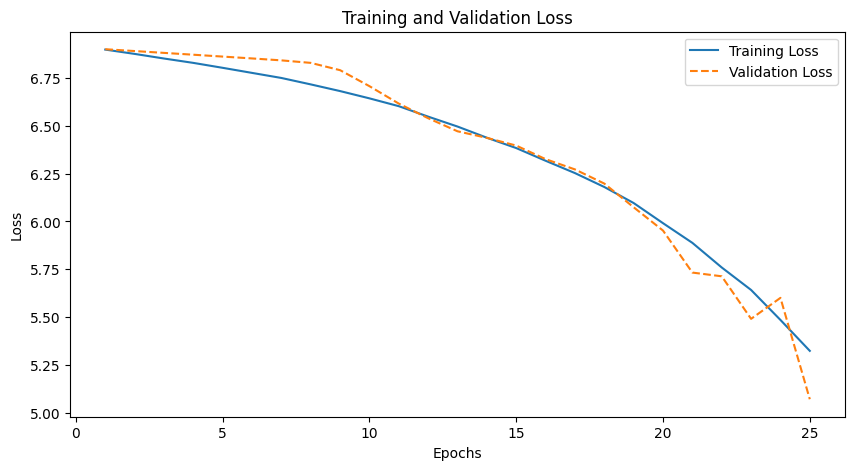

In [40]:
key = f"lr{batch_size}"
if key in train_loss_hyperparameters3 and key in val_acc_hyperparameters3:
    num_epochs_actual = len(train_loss_hyperparameters3[key])
    epochs = list(range(1, num_epochs_actual + 1))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_hyperparameters3[key], label='Training Loss')
    plt.plot(epochs, val_loss_hyperparameters3[key], label='Validation Loss', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



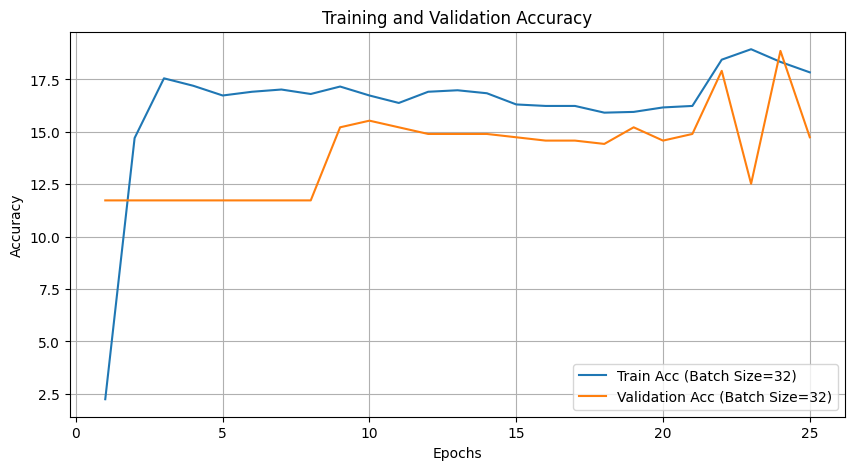

In [41]:
key = f"lr{batch_size}"
if key in train_loss_hyperparameters3 and key in val_acc_hyperparameters3:
    num_epochs_actual = len(train_loss_hyperparameters3[key])
    epochs = list(range(1, num_epochs_actual + 1))
    plt.figure(figsize=(10, 5))
    for batch_size in hyper_parameters["batch_size"]:
        plt.plot(epochs, train_acc_hyperparameters3[f"lr{batch_size}"], label=f'Train Acc (Batch Size={batch_size})')
        plt.plot(epochs, val_acc_hyperparameters3[f"lr{batch_size}"], label=f'Validation Acc (Batch Size={batch_size})')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [42]:
import time

def calculate_epoch_time(model, train_loader, criterion, optimizer, device):
    model.train()
    start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()

    epoch_time = end_time - start_time
    return epoch_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epoch_time = calculate_epoch_time(model, train_loader, criterion, optimizer, device)
print("Wall clock time for one epoch:", epoch_time, "seconds")


Wall clock time for one epoch: 11.405265808105469 seconds
